In [1]:
import os, zipfile

ZIP_PATH = 'chestxray.zip'       # adjust if your file has a different name
OUTPUT_DIR = 'chestxray14'

os.makedirs(OUTPUT_DIR, exist_ok=True)
with zipfile.ZipFile(ZIP_PATH, 'r') as z:
    z.extractall(OUTPUT_DIR)
print(f"Extracted to {OUTPUT_DIR}")


FileNotFoundError: [Errno 2] No such file or directory: 'chestxray.zip'

In [15]:
# ─── workaround for macOS / spawn pickling errors ─────────────────────────
import multiprocessing as mp

try:
    mp.set_start_method('fork', force=True)
    print("Successfully set multiprocessing start method to 'fork'")
except RuntimeError:
    # if it’s already been set, this will raise – safe to ignore
    pass
# ───────────────────────────────────────────────────────────────────────────


Successfully set multiprocessing start method to 'fork'


In [16]:
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms

# 2a) your SubsetWithTransform at top‑level of the notebook:
class SubsetWithTransform(Dataset):
    def __init__(self, base_ds, indices, transform):
        self.base_ds   = base_ds
        self.indices   = indices
        self.transform = transform
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, idx):
        img, label = self.base_ds[self.indices[idx]]
        return self.transform(img), label

# 2b) build raw_ds + split indices
raw_ds = ImageFolder("chestxray/chest_xray/train", transform=None)
val_size   = int(0.10 * len(raw_ds))
train_size = len(raw_ds) - val_size
train_idx, val_idx = random_split(list(range(len(raw_ds))), [train_size, val_size])

# 2c) define transforms
train_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
])
val_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
])

# 2d) wrap in subsets + DataLoaders
train_ds = SubsetWithTransform(raw_ds, train_idx, train_tf)
val_ds   = SubsetWithTransform(raw_ds, val_idx,   val_tf)
test_ds  = ImageFolder("chestxray/chest_xray/test", transform=val_tf)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=4)

print(f"Train / Val / Test sizes: {len(train_ds)} / {len(val_ds)} / {len(test_ds)}")


Train / Val / Test sizes: 4695 / 521 / 624


In [17]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=0)


In [19]:
# 3) Model, Loss & Optimizer

import torch.nn as nn
from torchvision import models

# a) device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on", device)

# b) load pretrained DenseNet‑121 and replace its head
model = models.densenet121(pretrained=True)
in_feats = model.classifier.in_features
model.classifier = nn.Linear(in_feats, 2)   # NORMAL vs PNEUMONIA
model = model.to(device)

# c) loss, optimizer (and optional scheduler)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", factor=0.5, patience=2
)

print(model)


Running on cpu
DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [20]:
# ─── Cell 4: train_one_epoch & eval_one_epoch ────────────────────────────────────

import torch.nn.functional as F

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss    += loss.item() * imgs.size(0)
        running_corrects+= (outputs.argmax(1) == labels).sum().item()

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc  = running_corrects / len(loader.dataset)
    return epoch_loss, epoch_acc

def eval_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            running_loss    += loss.item() * imgs.size(0)
            running_corrects+= (outputs.argmax(1) == labels).sum().item()

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc  = running_corrects / len(loader.dataset)
    return epoch_loss, epoch_acc


In [21]:
# ─── Cell 5: Training Loop ───────────────────────────────────────────────────────

NUM_EPOCHS = 10
best_val_acc = 0.0

for epoch in range(1, NUM_EPOCHS+1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss,   val_acc   = eval_one_epoch(model, val_loader,   criterion, device)
    
    # step LR scheduler
    scheduler.step(val_acc)
    
    print(f"Epoch {epoch:02d} | "
          f"Train Loss: {train_loss:.3f} | Train Acc: {train_acc:.3%} || "
          f"Val   Loss: {val_loss:.3f} | Val   Acc: {val_acc:.3%}")
    
    # save best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_densenet121.pt")
        print("  ↳ New best val acc, checkpoint saved.")


Epoch 01 | Train Loss: 0.112 | Train Acc: 95.911% || Val   Loss: 0.059 | Val   Acc: 97.889%
  ↳ New best val acc, checkpoint saved.
Epoch 02 | Train Loss: 0.040 | Train Acc: 98.701% || Val   Loss: 0.048 | Val   Acc: 97.697%
Epoch 03 | Train Loss: 0.027 | Train Acc: 99.127% || Val   Loss: 0.017 | Val   Acc: 99.424%
  ↳ New best val acc, checkpoint saved.
Epoch 04 | Train Loss: 0.013 | Train Acc: 99.723% || Val   Loss: 0.027 | Val   Acc: 99.232%


KeyboardInterrupt: 

In [25]:
# ─── Cell 6: Test‑set evaluation ─────────────────────────────────────────────

import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score

# 6.1) Load best checkpoint
model.load_state_dict(torch.load("best_densenet121.pt"))
model.eval()

# 6.2) Gather predictions & labels
all_labels = []
all_probs  = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        logits = model(imgs)
        probs  = F.softmax(logits, dim=1)[:,1].cpu().tolist()
        all_probs.extend(probs)
        all_labels.extend(labels.tolist())

# 6.3) Compute metrics
preds = [1 if p>0.5 else 0 for p in all_probs]
auc    = roc_auc_score(all_labels, all_probs)
acc    = accuracy_score(all_labels, preds)
cm     = confusion_matrix(all_labels, preds)

print(f"Test  ROC‑AUC: {auc:.3f}")
print(f"Test Accuracy: {acc:.3%}")
print("Confusion Matrix:\n", cm)


Test  ROC‑AUC: 0.924
Test Accuracy: 75.160%
Confusion Matrix:
 [[ 80 154]
 [  1 389]]


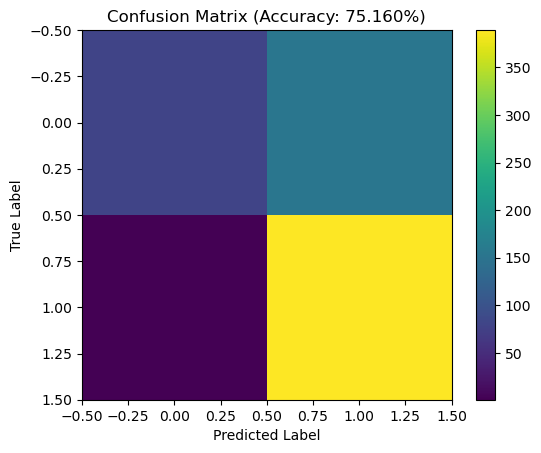

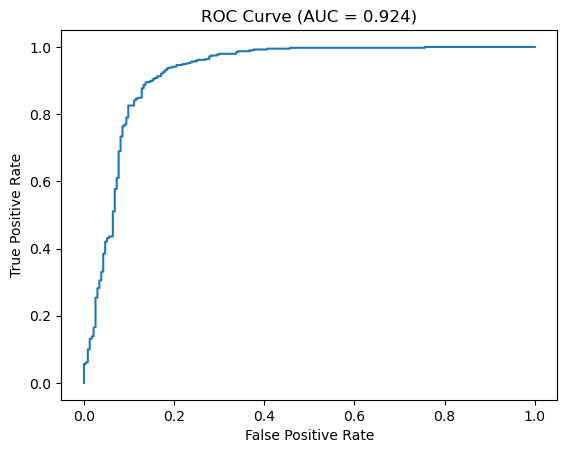

In [26]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score

# 1) Gather predictions & labels from the test set
all_labels = []
all_probs  = []
model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        logits = model(imgs)
        probs  = F.softmax(logits, dim=1)[:,1].cpu().tolist()
        all_probs.extend(probs)
        all_labels.extend(labels.tolist())

# 2) Compute confusion matrix & accuracy
preds = [1 if p>0.5 else 0 for p in all_probs]
cm    = confusion_matrix(all_labels, preds)
acc   = accuracy_score(all_labels, preds)

# 3) Plot confusion matrix heatmap
plt.figure()
plt.imshow(cm)
plt.title(f"Confusion Matrix (Accuracy: {acc:.3%})")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.colorbar()
plt.show()

# 4) Compute ROC curve & AUC
fpr, tpr, _ = roc_curve(all_labels, all_probs)
auc = roc_auc_score(all_labels, all_probs)

# 5) Plot ROC curve
plt.figure()
plt.plot(fpr, tpr)
plt.title(f"ROC Curve (AUC = {auc:.3f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()
